# Optimizing Covid19 testing locations and extra beds 

This is an exploratory notebook that prototypes a "data good" to help face the covid19 crisis. This project is done under the World Bank's [Data Partnership](https://datapartnership.org/). 

We are guided by the suggestions and pointers given in our covid19 meetings on the subject with experts across the World Bank and external partners.

This "data good" estimates, for any given country, two things:
* Where else a government can locate covid19 *additional testing locations* beyond their current health facilities. The recommendation are optimized for places serving the most people furthest from any current location.
* Where else *extra hospital beds* might be needed. The recommendation uses current elderly population served for each hospital versus total population served and current hospital bed capacity.

## Setup


If you are running ddp code for the first time, you may need to install the library that includes many helper functions to easy access to partner data.

You need to be a added to the [Github repository](https://github.com/datapartnership/devdatapartnership) to get access. If you cannot see it, you don't have access to install the library. If so, please contact datapartnership@worldbank.org with your Github username to get added to the repository.

```sh
conda create -n ddp python=3
conda activate ddp
/path/to/python -m pip install -e git+ssh://git@github.com/datapartnership/devdatapartnership.git#egg=devdatapartnership
```
Note: You need to restart the kernel to be able to import after install

In [1]:
#import sys ; sys.executable

### Authenticate using DDP credentials


In [3]:
import os
from pathlib import Path
from dotenv import load_dotenv
env_path = Path('~/')/'.ddp' / '.env'
load_dotenv(dotenv_path=env_path)
load_dotenv(override=True);
MAPBOX_ACCESS_TOKEN = os.getenv("MAPBOX_ACCESS_TOKEN")

location='Spain'
data_folder=Path('.')/'data'/location


## Accesibility to health facilities

This section explores who to measure accesibility, in minutes, to health facilities. 

We will assume that a region needs to know how far away (by car) their entire population is from their closest hospital. You can use this to see regions that are too far away, or where to locate additional services that cater those most in need.

### Setting the routing engine

One of our partners, Mapbox, offers traffic-aware global travel times. We will set up the functions to calculate distance in minutes walking, biking, driving and driving with real-time traffic.

In [4]:
#Simple point to point call

import requests  #http framework to make Mapbox Matric API requests for routes
import json # handle response as json
import datetime # save timestamp

osrm_server="https://api.mapbox.com/directions-matrix/v1/mapbox/"
modes=['driving-traffic', 'driving', 'cycling', 'walking']
mode = modes[1]
url=osrm_server+mode+'/'
params="?annotations=distance,duration&access_token="+MAPBOX_ACCESS_TOKEN
comma="%2C"
sep="%3B"

origin=[43.394020,-5.706718]
destination=[43.523757,-6.047233]
fullurl=url+str(origin[1])+','+str(origin[0])+";"+str(destination[1])+','+str(destination[0])+params
response = requests.get(fullurl) #do the request
response.raise_for_status() # ensure we notice bad responses
response=json.loads(response.text)
#print(response)
print, fullurl
print("Between La Corrada and Noreña there are %2.1f km and ~%2.0f minutes driving."%
      (response['distances'][0][1]/1000.,
       response['durations'][0][1]/60.))

Between La Corrada and Noreña there are 49.8 km and ~35 minutes driving.


### Data we need

1. Origins: From where to start to travel time (population centers, zip codes, cities, ...)
2. Population on origins: How many people are located at the origin?
3. Destinations: The set of destinations. Health facilities in this case

In our case, as a proxy for 1. and 2. we will use our partner Facebook and their [Disease Prevention Maps](https://dataforgood.fb.com/tools/disease-prevention-maps/). We also have estimates by age bracket at lower resoltion from [worldpop](https://www.worldpop.org/project/categories?id=8). We might use these on a later stage to estimate impact.

For 3 we use the hospitals and health centers from the [Ministry of Health](https://gist.github.com/brunosan/c1308568e1f488b0c4a7fd7045a48462)

This **proof of concept** is for Spain.


#### Population density

Disease prevention maps are essentially population density estimate. These are **huge** files where every pixel is ~21m^2. To manage the computation our strategy is to first cluster the country in windows of size e.g. `2000 pixels`. If the window has no population inside, we skip. If it does be split the window in 4 sub-windows, and repeat the process until the window has an arbitraty minimum size e.g. `125 pixels`.

In [6]:
#https://data.humdata.org/dataset/spain-high-resolution-population-density-maps-demographic-estimates
pop_density_url="https://data.humdata.org/dataset/80d0519e-0eaf-4c16-a16c-a10ca837a463/resource/fc271559-23ad-4d93-90f3-215d44ce0193/download/population_esp_2019-07-01_geotiff.zip"

In [ ]:
#Get the data
import urllib

print("Getting %s population data"%(location) )

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

pop_file=data_folder/'pop_density/'
if not os.path.exists(pop_file.with_suffix('.zip')):
    print("Downloading pop density")
    urllib.request.urlretrieve (pop_density_url,pop_file.with_suffix('.zip'))
if not os.path.exists(pop_file):
    print("Unzipping pop density")
    urllib.request.urlretrieve (pop_density_url,pop_file)

In [368]:
#TODO get this file
pop_file=data_folder/'population_esp_2019-07-01_geotiff/'
map_file=pop_file/'population_esp_2019-07-01.tif'
print("Map file: %s"%map_file)

Map file: data/Spain/population_esp_2019-07-01_geotiff/population_esp_2019-07-01.tif


In [367]:
import numpy as np
import rasterio
import pandas as pd
from rasterio.windows import Window
from matplotlib import pyplot


def get_pop(map_file,left_x,top_y,window,plot=False):
    """
    get_pop(raster filename,left_x,top_y,window,plot=False)
    
    Given a raster file, and row,cols ranges,
    return the lonlat of the ranges, nancount, and the nunsum
    
    Optionally plot the raster window [False]
    """
    right_x,bottom_y = left_x + window, top_y + window
    with rasterio.open(map_file) as src:
        left_lon, top_lat = src.xy(top_y,left_x )
        right_lon, bottom_lat = src.xy(bottom_y, right_x )
        center_lon , center_lat = (right_lon + left_lon)/2., (top_lat+bottom_lat)/2.
                             #Window(col_off, row_off, width, height)
        w = src.read(1, window=Window(left_x, top_y, window, window))
        if plot:
            pyplot.imshow(w, cmap='pink')
            pyplot.show()
        nancount=np.count_nonzero(~np.isnan(w))
        count = np.size(w)
        tot_pop=np.nansum(w)
    if count == 0:
        return {} #Out of bounds
    if tot_pop == 0 or window < 1: #Mark the window to furhter split.
        split=False
    else:
        split=True
    out={'window':window,
         'left_x':left_x,
         'right_x':right_x,
         'top_y':top_y,
         'bottom_y':bottom_y,
         'left_lon':left_lon, 
         'top_lat':top_lat, 
         'right_lon':right_lon,
         'bottom_lat':bottom_lat,
         'center_lon':center_lon , 
         'center_lat':center_lat,
         'count': count,
         'nancount':nancount,
         'tot_pop':tot_pop,
         'split': split}
    return out

In [ ]:
#Scan the raster map with big windows
origins=pd.DataFrame()
window=2000
with rasterio.open(map_file) as src:
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_pop(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")

In [12]:
def split(map_file,origin,plot=False):
    """
    Split a window row in 4 parts, and return new rows results
    """
    origins=pd.DataFrame()
    
    window=int(origin.window/2)
    for left_x in np.arange(origin.left_x,origin.right_x,window):
        for top_y in np.arange(origin.top_y,origin.bottom_y,window):
            out=get_pop(map_file,left_x,top_y,window,plot=plot)
            if out != {}:
                origins=origins.append([out])
    return origins

In [11]:
#Do a splitting pass. Run this cell sevral times,
# until you have a balance of small window and not too big rois
#run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("done.")
print("We now have %i regions of min size %i, %i will be split in next round"%\
      (len(origins),origins['window'].min(),len(origins[origins['split']==True])))

3064 regions need splitting
done.5554
We now have 17806 regions of min size 250, 11662 will be split in next round


In [12]:
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 11662 regions of size 250, 11662 with population >0


In [13]:
#make it geopandas settin a bounding box
import geopandas as gdp
from shapely.geometry import Point
from shapely.geometry import box
origins=gdp.GeoDataFrame(origins,crs='epsg:4327', geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)
origins.head(2)

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,geometry
0,250,500,750,53750,54000,-18.017500,28.864444,-17.948056,28.795,-17.982778,28.829722,62500,217,185.567990,True,POINT (-17.98278 28.82972)
0,250,750,1000,53750,54000,-17.948056,28.864444,-17.878611,28.795,-17.913333,28.829722,62500,768,656.756757,True,POINT (-17.91333 28.82972)


#### Hospital destination

In [13]:
hospitals_file=data_folder/'hospitales.geojson'
print("Destination file: %s"%hospitals_file)

Destination file: data/Spain/hospitales.geojson


In [14]:
import contextily as ctx
import geopandas as gpd

hospitals = gpd.read_file(hospitals_file).to_crs('epsg:3857')
hospitals['geometry'] = hospitals['geometry'].centroid

/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


There are 924 hospital destinations


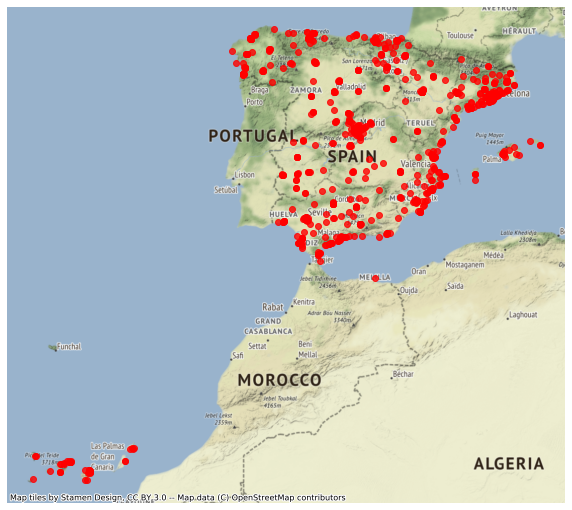

In [15]:
hospitals['lat']=hospitals.to_crs("epsg:4327").geometry.y
hospitals['lon']=hospitals.to_crs("epsg:4327").geometry.x

ax = hospitals.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)
ax.set_axis_off()
print("There are %i hospital destinations"%len(hospitals))

In [26]:
hospitals.head(2)

,CODCNH,NOMBRE,Dir,Latitude,Longitude,TELEFONO,NCAMAS,FINALIDAD ASISITENCIAL,DEPENDENCIA PATRIMONIAL,DEPENDENCIA FUNCIONAL,...,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL,geometry,lat,lon
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁ...,"ÁLAVA, 43 Vitoria-Gasteiz 01006 ÁLAVA",42.836115,-2.678953,945006555.0,207,PSIQUIÁTRICO,COMUNIDAD AUTÓNOMA,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,0,0,0,0,0,0,0,POINT (-298219.673 5287060.008),42.836115,-2.678953
1,10040,HOSPITAL SAN JOSÉ,"BEATO TOMÁS DE ZUMÁRRAGA, 10 Vitoria-Gasteiz 0...",42.849893,-2.676568,945140900.0,63,MÉDICO-QUIRÚRGICO,PRIVADO NO BENÉFICO,PRIVADO NO BENÉFICO,...,0,0,0,0,1,1,1,POINT (-297954.165 5289151.838),42.849893,-2.676568


### Gather travel times

In [309]:
def n_closest_geodetic(destinations,origins,n_keep,verbose=False):
    """
    Given a list of origins and destinations, return the "keep" number
    of destinations that are closest geodetically to each origin.
    
    Input: destinations,origins <Geopandas>
    Output: destinations filtered <Geopandas>
    """
    destinations=destinations.to_crs(origins.crs)
    filtered=gdp.GeoDataFrame()
    if verbose:
        i=0
        l=len(origins.index)
    for index in origins.index:
        if verbose:
            i=i+1
            print("Doing %i of %i\r"%(i,l),end="")
        distances=destinations.distance(origins.loc[index].geometry)
        if len(distances) < n_keep:
            n_keep = len(distances)
        #query indices
        indices=np.argsort(distances.values)[:n_keep]
        values=np.sort(distances.values)[:n_keep]
        #destination indices
        d_indices=distances.index[indices]
        filtered = filtered.append(destinations.iloc[indices])
    if verbose:
        print('done')
    return filtered.append(filtered).drop_duplicates(inplace=False)


In [18]:
test_o = origins.sample(frac=1).reset_index(drop=True).head(10)
test_d = hospitals.sample(frac=1).reset_index(drop=True).head(10)
filtered = n_closest_geodetic(test_d,test_o,2,verbose=False)

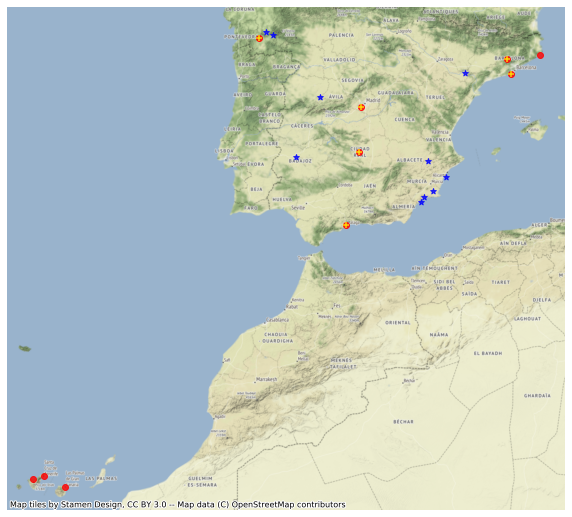

In [19]:
import contextily as ctx
ax = test_d.to_crs('epsg:3857').plot(figsize=(10, 10), alpha=0.8,color='red')
filtered.to_crs('epsg:3857').plot(figsize=(10, 10), alpha=0.8,color='yellow',marker='+',ax=ax)
test_o.to_crs('epsg:3857').plot(figsize=(10, 10), alpha=0.8,color='blue',marker='*',ax=ax)
ctx.add_basemap(ax,zoom=7)
ax.set_axis_off()

In [247]:
#reset index to be incerasing integers

h=hospitals.reset_index(drop=True)
h.head(1)

,CODCNH,NOMBRE,Dir,Latitude,Longitude,TELEFONO,NCAMAS,FINALIDAD ASISITENCIAL,DEPENDENCIA PATRIMONIAL,DEPENDENCIA FUNCIONAL,...,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL,geometry,lat,lon
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁ...,"ÁLAVA, 43 Vitoria-Gasteiz 01006 ÁLAVA",42.836115,-2.678953,945006555.0,207,PSIQUIÁTRICO,COMUNIDAD AUTÓNOMA,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,0,0,0,0,0,0,0,POINT (-298219.673 5287060.008),42.836115,-2.678953


In [ ]:
o=origins.reset_index(drop=True)

In [254]:
import pickle
#SAVE
with open(data_folder/'h-o12k.pickle', 'wb') as handle:
    pickle.dump([h,o], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle
#LOAD
with open(data_folder/'h-o52k.pickle', 'rb') as handle:
    h,o = pickle.load(handle)

In [350]:
import pandas as pd 
import numpy as np
import geopandas as gdp
def mapbox_matrix_API(origins, destinations, mode=1, name='poi',destination_id_col=False,n_keep=5,do_all=False,verbose=True):
    """
    Given a geopandas set of origins and destinations, return the origins with extra columns
    with the closest destination in minutes given the mode of transportation for each origin.
    
    Also returns the snap distance to the origin (geodetic distance from origin point to closest road)
    Keywords:
    do_all [False]: By default avoid repeating work that has been done.
    
    """
    osrm_server="https://api.mapbox.com/directions-matrix/v1/mapbox/"
    modes=['driving-traffic', 'driving', 'cycling', 'walking']
    url=osrm_server+modes[mode]+'/'
    params="?annotations=distance,duration&access_token="+MAPBOX_ACCESS_TOKEN


    o_type=name
    batch=int(np.floor(24/n_keep))
    

    if n_keep*batch>25:
        print("limit 25< %i (keep) * %i (batch)"%(n_keep,batch))

    cols=['t_'+o_type,'m_'+o_type,'so_'+o_type]
    
    #only do empty ones
    if not do_all:
        queued_origins=origins[origins['t_hospital']==-1]
    else:
        queued_origins=origins
    if verbose:
        print("Doing %i"%len(queued_origins))
    try:
        for i in np.arange(queued_origins.shape[0]/batch):
            print("Doing batch %i, from %i to %i, of %i"
              %(i+1,batch*i,batch*(i+1),queued_origins.shape[0]),end="\r")
            #get origin batch
            o_batch=queued_origins.iloc[int(batch*i):].head(n=batch)


            #to reduce API calls calculate keep only n closest (geodetically) to
            #each origin.
            h_batch=n_closest_geodetic(destinations,o_batch,n_keep)
            h_batch_loc=\
            ";".join([",".join([str(row.centroid.x),str(row.centroid.y)]) for row in h_batch['geometry']])

            #create url params of origin batch
            d=\
            ";".join([",".join([str(row.centroid.x),str(row.centroid.y)]) for row in o_batch['geometry']])
            d_name=o_batch.index

            trail=".json?destinations="+\
            ';'.join([str(x) for x in np.arange(len(h_batch))])+\
            "&sources="+\
            ';'.join([str(x) for x in np.arange(len(h_batch),len(h_batch)+len(o_batch))])

            fullurl= url+h_batch_loc+";"+d+trail+params

            #print(fullurl)
            response = requests.get(fullurl)
            response.raise_for_status()
            response=json.loads(response.text)
            #print(response)
            response_matrix=response['durations']
            durations=[]
            h_min=[]
            for origin in np.arange(np.shape(response_matrix)[0]):
                durations+=[min(response_matrix[origin])]
                h_min+=[np.argmin(response_matrix[origin])]
            for i in np.arange(len(durations)):
                queued_origins.loc[[d_name[i]], ['t_'+o_type]]=durations[i]/60./60.
                if destination_id_col != False:
                    queued_origins.loc[[d_name[i]], ['m_'+o_type]] = h_batch.iloc[h_min[i]][destination_id_col]
                queued_origins.loc[[d_name[i]], ['so_'+o_type]]=response['sources'][i]['distance']
    except Exception as err:
        print("Error. Work done has been saved and returned. \nError:",err.args)
    print("\n")
    #update the "origins" with the results
    
    pd.set_option('mode.chained_assignment', None) #'warn'
    origins.loc[queued_origins.index, (cols)] = queued_origins.loc[:,(cols)].copy()
    print("returning")
    
    return origins


In [31]:
#initialize columns
o_type = 'hospital'
cols=['t_'+o_type,'m_'+o_type,'so_'+o_type]
for col in cols:
    o[col]=-1

In [ ]:
#HTTP API calls fail sometimes (I have a bad connection),
#So I try several times. 
#(On failure, we save the results so next time it resumes where it left)
tries = 0
while tries < 10:
    o = mapbox_matrix_API(o, h, name='hospital',n_keep=5,verbose=True)
    tries+=1

In [255]:
o.to_file(data_folder/"origins.geojson", driver='GeoJSON')

In [256]:
h.to_file(data_folder/"h.geojson", driver='GeoJSON')

In [301]:
import geopandas as gdp 
o=gdp.read_file(data_folder/"origins.geojson")
h=gdp.read_file(data_folder/"h.geojson")

### Results, where people are furthest from any hospital

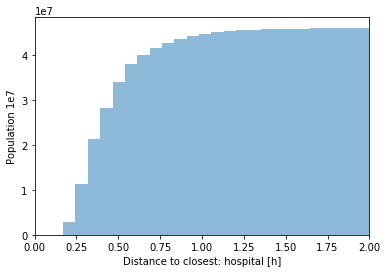

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
o['t_'+o_type].plot.hist(alpha=0.5,bins=100,cumulative=True,density=False,log=False,logx=False,weights=o['tot_pop'])
plt.xlim((0,2))
plt.ylabel('Population 1e7')
plt.xlabel('Distance to closest: '+o_type+' [h]')
plt.show()

In [365]:
from matplotlib import gridspec
import contextily as ctx

def biplot(t_max,so_max=10000,xlim=False):
    """
    Plot a map and an histogram for the places beyong t_max hours from closest hospital.
    Excludes places where the closest road is boeyond s_max meters
    """
    o_above = o[(o['t_'+o_type]>t_max) & (o['so_'+o_type]<so_max)]
    
    fig = plt.figure(figsize=(12, 6)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

    ax1=plt.subplot(gs[0])

    o_above.to_crs('epsg:3857').plot( alpha=0.8,color='red',ax=ax1,linewidth=100)
    h.to_crs('epsg:3857').plot( alpha=0.8,color='blue',marker=".",markersize=8,ax=ax1)
    
    ctx.add_basemap(ax1,zoom=7)
    ax1.set_title("(Red) population beyond %i h from hospital (Blue)"%t_max)
    ax1.set_axis_off()
    
    ax2=plt.subplot(gs[1])
    o['t_'+o_type].plot.hist(alpha=0.5,bins=100,cumulative=True,density=False,log=False,logx=False,weights=o['tot_pop'])
    if len(xlim)>0:
        plt.xlim(xlim)
    ax2.ticklabel_format(style='sci')
    ax2.axvline(t_max,color="red")
    ax2.set_ylabel('People [10s Million]')
    ax2.set_xlabel('Distance to closest: '+o_type+' [h]')
    ax2.set_title("%i people (%.2f%%) > %i h driving hospital"%\
     (o_above['tot_pop'].sum(),o_above['tot_pop'].sum()/o['tot_pop'].sum()*100,t_max))

    #plt.tight_layout()
    plt.savefig('Senegal-threshold-%i.pdf'%t_max)
    plt.show();

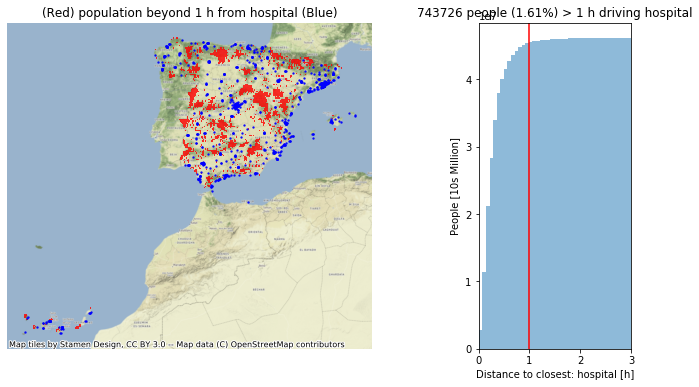

In [270]:
biplot(1,xlim=(0,3))

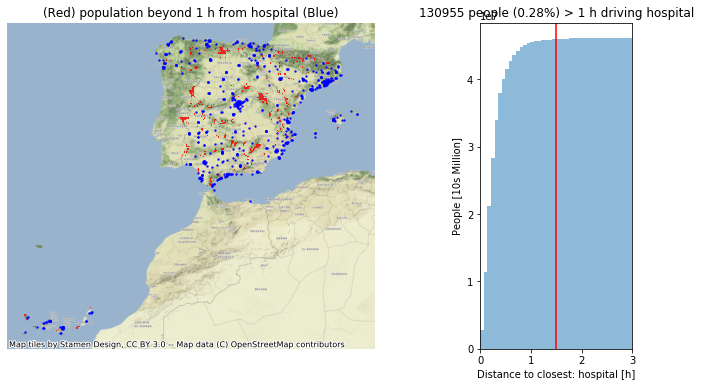

In [272]:
biplot(1.5,xlim=(0,3))

### Styled map

This is a style map using Mapbox Studio. Each block is the unit of population (we can make them as small as `27mx27m`, but this works as a prototype). Transparency is proportional to population, color is green for places within 1 hour driving to any hospital ("flag" icons), yellow for 1 to 1.5 hours and red beyond 1.5 hours. If you zoom in, it shows the estimate of population within the block. Click through for live map.

[![](https://api.mapbox.com/styles/v1/brunosan/ck7tmxdao01og1io2d4wir16v/static/-3.217877,39.927849,5,0.00,0.00/600x600@2x?access_token=pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg)](https://api.mapbox.com/styles/v1/brunosan/ck7tmxdao01og1io2d4wir16v.html?fresh=true&title=copy&access_token=pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg)

# Estimate needs for extra beds

To do this, we cluster all beds within 1km2, as sometimes hospitals are clustered and one can assume patients can be distributed within these clusters. We also drop all hospitals without beds (usually testing clinics.

## Network of hospital beds

In [248]:
#drop hospitals with no beds
h2=h[h['NCAMAS']>0]
print("%i hospitals with beds, out of %i"%(len(h2),len(h)))

809 hospitals with beds, out of 924


In [281]:
#buffer roughly 5km
clusters=h2.to_crs('epsg:3857').geometry.buffer(5000).unary_union
#Make it geopandas
clusters=gpd.GeoDataFrame([polygon for polygon in clusters],crs='epsg:3857').set_geometry(0)
len(clusters)

252

In [282]:
#tag each hospital with their cluster
h_clusters=gpd.sjoin(h2, clusters, how='inner')

In [283]:
keep_cols=['geometry', 'NCAMAS','TAC', 'RM', 'GAM', 'HEM', 'ASD', 'LIT', 'BCO', 'ALI', 'SPECT', 'PET',
       'MAMOS', 'DO', 'DIAL']
h_clusters=h_clusters.dissolve(by='index_right', aggfunc='sum')[keep_cols]
print(len(h_clusters))
h_clusters.head(2)

252


,geometry,NCAMAS,TAC,RM,GAM,HEM,ASD,LIT,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL
index_right,,,,,,,,,,,,,,,
0,POINT (-1994358.809 3225593.183),32,1,0,0,0,0,0,0,0,0,0,1,0,9
1,"MULTIPOINT (-1737388.562 3217466.639, -1730121...",228,2,2,0,0,0,1,0,0,0,0,3,2,20


In [353]:
h_clusters['index']=h_clusters.index

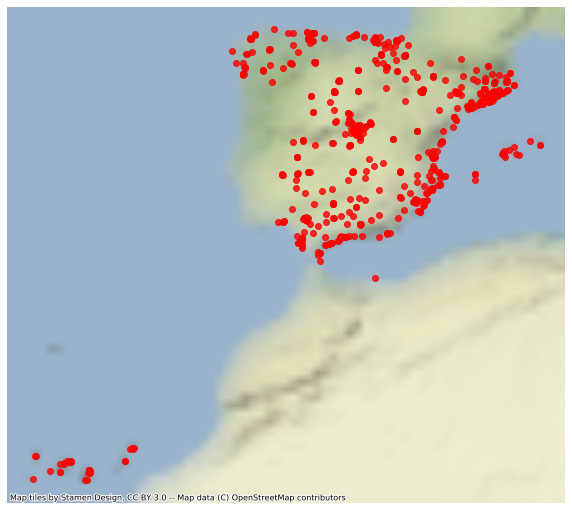

In [288]:
import contextily as ctx
ax = h_clusters.to_crs('epsg:3857').plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax,zoom=2)
ax.set_axis_off()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
o['t_'+o_type].plot.hist(alpha=0.5,bins=100,cumulative=True,density=False,log=False,logx=False,weights=o['tot_pop'])
plt.xlim((0,2))
plt.ylabel('Population 1e7')
plt.xlabel('Distance to closest: '+o_type+' [h]')
plt.show()

In [302]:
import geopandas as gdp 
o=gdp.read_file(data_folder/"origins.geojson")

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,m_hospital,so_hospital,geometry
0,250,500,750,53750,54000,-18.0175,28.864444,-17.948056,28.795,-17.982778,28.829722,62500,217,185.56799,1,1.650472,380316,1825.243192,"POLYGON ((-18.01750 28.79500, -18.01750 28.864..."


In [357]:
o['t_hospital']=-1

In [ ]:
tries = 0
while tries < 1000:
    o = mapbox_matrix_API(o, h_clusters, name='hospital', destination_id_col='index',n_keep=5,verbose=True)
    tries+=1

In [361]:
o.to_file(data_folder/"origins_beds.geojson", driver='GeoJSON')

In [363]:
o_type='hospital'
totals=o[o['t_'+o_type]<0.5].groupby('m_hospital').sum().sort_values(by='tot_pop',ascending=False)['tot_pop']

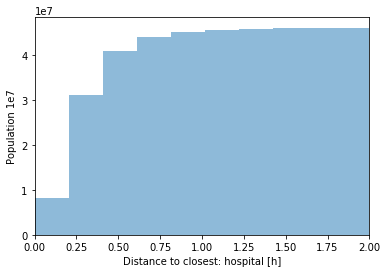

In [369]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
o['t_'+o_type].plot.hist(alpha=0.5,bins=100,cumulative=True,density=False,log=False,logx=False,weights=o['tot_pop'])
plt.xlim((0,2))
plt.ylabel('Population 1e7')
plt.xlabel('Distance to closest: '+o_type+' [h]')
plt.show()

/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


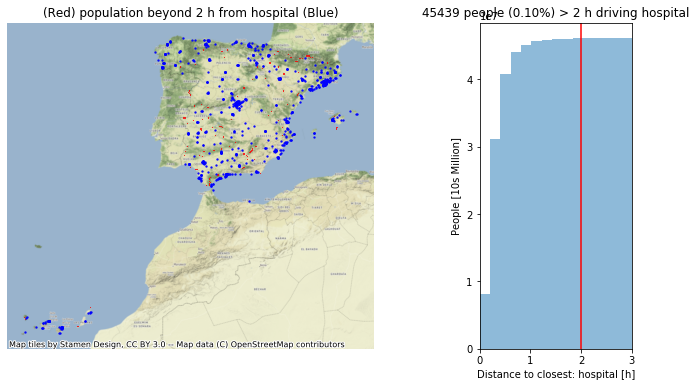

In [371]:
biplot(2,xlim=(0,3))

In [372]:
#TODO get this file
pop_file=data_folder/'esp_elderly_60_plus_geotiff/'
map_file=pop_file/'ESP_elderly_60_plus.tif'
print("Map file: %s"%map_file)

Map file: data/Spain/esp_elderly_60_plus_geotiff/ESP_elderly_60_plus.tif


In [384]:
##TODO
#insert population numbers for 60+ ages from file into variable "o"

In [383]:
o.head(1)

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,m_hospital,so_hospital,geometry,tot_pop_60+
0,250,500,750,53750,54000,-18.0175,28.864444,-17.948056,28.795,-17.982778,28.829722,62500,217,185.56799,1,1.821306,9,1825.243192,"POLYGON ((-18.01750 28.79500, -18.01750 28.864...",72.611455


In [386]:
h['tot_pop_60+']=0

In [387]:
totals=o.groupby('m_hospital').sum().sort_values(by='tot_pop_60+',ascending=False)['tot_pop_60+']
totals

m_hospital
171    702625.739218
121    407959.396171
137    359750.782044
118    323899.304667
81     259050.704343
           ...      
140      3219.429139
175      2915.139180
0        2896.607692
70       1874.314260
106      1408.251626
Name: tot_pop_60+, Length: 251, dtype: float64

In [388]:
h.loc[totals.index,'tot_pop_60+']=totals.values

In [389]:
h.head(2)

,CODCNH,NOMBRE,Dir,Latitude,Longitude,TELEFONO,NCAMAS,FINALIDAD ASISITENCIAL,DEPENDENCIA PATRIMONIAL,DEPENDENCIA FUNCIONAL,...,PET,MAMOS,DO,DIAL,lat,lon,tot_pop,geometry,tot_pop_60,tot_pop_60+
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁ...,"ÁLAVA, 43 Vitoria-Gasteiz 01006 ÁLAVA",42.836115,-2.678953,945006555.0,207,PSIQUIÁTRICO,COMUNIDAD AUTÓNOMA,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,0,0,0,0,42.836115,-2.678953,4925.121776,POINT (-298219.673 5287060.008),0,2896.607692
1,10040,HOSPITAL SAN JOSÉ,"BEATO TOMÁS DE ZUMÁRRAGA, 10 Vitoria-Gasteiz 0...",42.849893,-2.676568,945140900.0,63,MÉDICO-QUIRÚRGICO,PRIVADO NO BENÉFICO,PRIVADO NO BENÉFICO,...,0,1,1,1,42.849893,-2.676568,0.000000,POINT (-297954.165 5289151.838),0,27614.274656


In [390]:
h.to_file("h2.geojson", driver='GeoJSON')

(1000.0, 1000000.0)

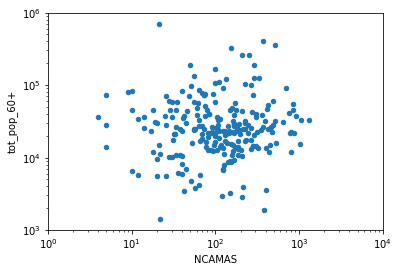

In [405]:
ax = pd.DataFrame(h).plot.scatter(x='NCAMAS',y='tot_pop_60+')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e0,1e4) #camas
ax.set_ylim(1e3,1e6) #pop

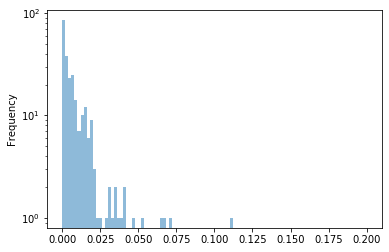

In [428]:
h['c_p']=h['NCAMAS']/h['tot_pop_60+']
h['c_p'].plot.hist(alpha=0.5,bins=100,cumulative=False,density=False,log=True,logx=False,range=(0,0.2))

/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


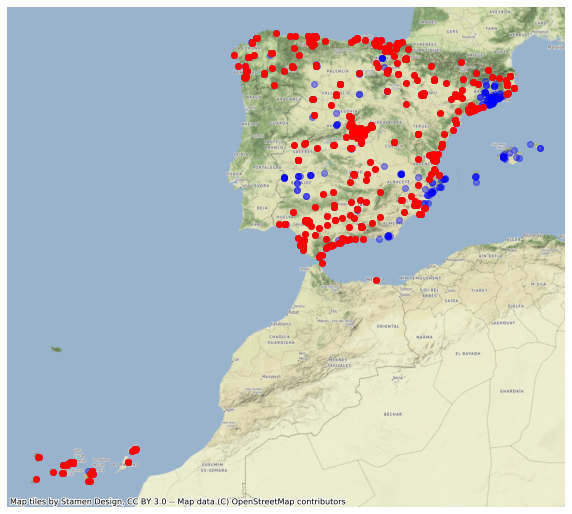

In [442]:
import contextily as ctx
ax = h.to_crs('epsg:3857').plot(figsize=(10, 10), alpha=0.4,color='blue')
h[h['c_p']>1e20].to_crs('epsg:3857').plot(alpha=1,color='red',ax=ax)
ctx.add_basemap(ax,zoom=7)
ax.set_axis_off()